In [1]:
include("src/SpinonStructure.jl")
include("src/BZMath.jl")
# include("PyrochloreGeometry.jl")
# import .PyrochloreGeometry as geom
using .BZmath
using .SpinonStructure
using LinearAlgebra
using StaticArrays
using BenchmarkTools
using Plots


In [2]:
@inline function gaussian(x,σ)
    local N = 1/√(2π)
    return N*exp(-0.5*(x/σ)^2)/σ
end

@inline function Lorentzian(x, Γ)
    local N = 1/π
    Γ /= 2
    return N*1. * Γ/(x^2 + Γ^2)
end

Lorentzian (generic function with 1 method)

In [3]:
A_dict = Dict(
    "0flux_big"=>load_A("gaugefiles/0_flux_big.gauge"),
    "0flux" => load_A("gaugefiles/0_flux_manual.gauge"),
    "πflux" => [ 0 0 π π ; 0 0 0 0; 0 0 π π; 0 0 0 0 ],
    "ππ00" =>  [ 0 0 0 π ; 0 0 0 0; 0 0 0 π; 0 0 0 0 ],
    "FF_even"=>load_A("gaugefiles/FF_even_pi18.gauge")
    )

high_symmetry_points = Dict(
    "\\Gamma"=> [0.,0.,0.],
    "X"=> [1.,0.,0.],
    "W"=> [1.,0.5,0.],
    "K"=> [0.75,0.75,0.],
    "L"=> [0.5,0.5,0.5],
    "U"=> [1.0, 0.25,0.25]
)

Dict{String, Vector{Float64}} with 6 entries:
  "U"       => [1.0, 0.25, 0.25]
  "W"       => [1.0, 0.5, 0.0]
  "X"       => [1.0, 0.0, 0.0]
  "\\Gamma" => [0.0, 0.0, 0.0]
  "L"       => [0.5, 0.5, 0.5]
  "K"       => [0.75, 0.75, 0.0]

In [4]:
"""
global_g must be a row vector
"""

function global_gauge(A_original, global_g)
    lat = geom.PyroFCC( round(Int, (size(A_original)[1]/4)^(1/3)) )
    
    A = copy(A_original) # make a copy
    # if local_g isa Vector{Float64}
    #     for (J, (t, Γ)) in enumerate(zip(lat.tetra_sites, local_g))
    #         eta =  1 if J <= length(lat.A_sites) else -1 
    #         for delta in geom.pyro
    #             A[geom.spin_idx(lat, t + eta*delta) += local_g
    #         end
    #     end
    # end
    return A_original .+ global_g
end
                
            

global_gauge (generic function with 1 method)

In [5]:
using JLD
using HDF5
using IJulia
using ProgressMeter

function simname(sim::SimulationParameters)
    return "output/SQW?name=$(sim.name)?Jpm=$(sim.Jpm)?B=$(sim.B).jld"
end
    
function save_SQW(;S::Matrix{ComplexF64}, bounds::Matrix{Float64}, Egrid::Vector{Float64}, BZ_path::BZPath,
        sim::SimulationParameters, 
        ip::IntegrationParameters)
    name = simname(sim)
    jldopen(name, "w") do file
        g1 = create_group(file, "integration_parameters")
        g1["n_K_samples"] = ip.n_K_samples
        g1["BZ_grid_density"] = ip.BZ_grid_density

        g = create_group(file, "physical_parameters")
        g["name"] = sim.name
        g["fluxes"] = sim.A
        g["Jpm"] = sim.Jpm
        g["B"] = sim.B
        g["lambda"] = sim.λ
        g["L"]=sim.lat.L

        d = create_group(file, "intensity") 
        d["S"] = S
        d["bounds"] = bounds
        # a list of K points, such that the I'th S slics corresponds to the I'th K point
        d["Q_list"] = path.K 
        d["tau"] = path.t
        d["ticks_tau"] = path.ticks_t
        d["ticks_label"] = path.ticks_label
        d["W"] = Egrid
    end
    return name
end
    


save_SQW (generic function with 1 method)

In [6]:
sim_0_Des = SimulationParameters("0flux_Des", A=A_dict["0flux"], Jpm=-0.046, B=zeros(3), nsample=1000, kappa=2.0)
sim_π_Des = SimulationParameters("piflux_Des", A=A_dict["πflux"], Jpm=1. /3, B=zeros(3), nsample=1000, kappa=2.0)
sim_π_Des_gauged = SimulationParameters("pi_Des_gauged",A=global_gauge(sim_π_Des.A, [ 0. 0. 0. π/2 ]),
    Jpm = sim_π_Des.Jpm,
    B = sim_π_Des.B,
    kappa=2.
    )


SimulationParameters([0.0 0.0 3.141592653589793 4.71238898038469; 0.0 0.0 0.0 1.5707963267948966; 0.0 0.0 3.141592653589793 4.71238898038469; 0.0 0.0 0.0 1.5707963267948966], 0.3333333333333333, [0.0, 0.0, 0.0], 0.3539812994172955, Main.SpinonStructure.PyrochloreGeometry.PyroFCC(1, SVector{3, Int64}[[0, 0, 0], [0, 4, 4], [4, 0, 4], [4, 4, 0], [2, 2, 2], [2, 6, 6], [6, 2, 6], [6, 6, 2]], SVector{3, Int64}[[0, 0, 0], [0, 4, 4], [4, 0, 4], [4, 4, 0]], SVector{3, Int64}[[1, 1, 1], [1, -1, -1], [-1, 1, -1], [-1, -1, 1], [1, 5, 5], [1, 3, 3], [-1, 5, 3], [-1, 3, 5], [5, 1, 5], [5, -1, 3], [3, 1, 3], [3, -1, 5], [5, 5, 1], [5, 3, -1], [3, 5, -1], [3, 3, 1]]), "pi_Des_gauged")

In [7]:
sim_0_crit_ππ00 = SimulationParameters("0flux_Des", A=A_dict["0flux"], Jpm=-0.05, B=0.25*[1,1,0]/√2, nsample=100000, kappa=2.0)

SimulationParameters([0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0], -0.05, [0.17677669529663687, 0.17677669529663687, 0.0], 0.17516441051049703, Main.SpinonStructure.PyrochloreGeometry.PyroFCC(1, SVector{3, Int64}[[0, 0, 0], [0, 4, 4], [4, 0, 4], [4, 4, 0], [2, 2, 2], [2, 6, 6], [6, 2, 6], [6, 6, 2]], SVector{3, Int64}[[0, 0, 0], [0, 4, 4], [4, 0, 4], [4, 4, 0]], SVector{3, Int64}[[1, 1, 1], [1, -1, -1], [-1, 1, -1], [-1, -1, 1], [1, 5, 5], [1, 3, 3], [-1, 5, 3], [-1, 3, 5], [5, 1, 5], [5, -1, 3], [3, 1, 3], [3, -1, 5], [5, 5, 1], [5, 3, -1], [3, 5, -1], [3, 3, 1]]), "0flux_Des")

In [156]:
# 0-flux + [111] magnetic field
dict_sim_0 = map(
    b->SimulationParameters("0flux_Des", A=A_dict["0flux"], Jpm=-0.046, B=b*ones(3)/√3, nsample=1000, kappa=2.0),
    [0,0.01,0.02,0.03,0.04,0.05]
    );

In [159]:
path = generate_path(high_symmetry_points, split("\\Gamma X W K \\Gamma L U W"), points_per_unit=150, K_units=2π/8);

In [10]:
using Printf

function plot_spinons(sim)
    E = []
    @showprogress for k in path.K
        push!(E, spinon_dispersion(k, sim )[1]')
    end
    E = reduce(vcat, E)

    plot(path.t,E,legend=false,color=:black,lw=0.5)
    xticks!(path.ticks_t, path.ticks_label)
    ylims!(0.,maximum(E))

    bstr = @sprintf("[%.3f,%.3f,%.3f]",sim.B[1],sim.B[2],sim.B[3])  
    if norm( abs.(sim.B/norm(sim.B))- [1,1,1]/√3) < 1e-8
        bstr = @sprintf("%.3f [1,1,1]/\\sqrt{3}", norm(sim.B) )
    elseif norm( abs.(sim.B/norm(sim.B))- [1,1,0]/√2) < 1e-8
        bstr = @sprintf("%.3f [1,1,0]/\\sqrt{2}", norm(sim.B))
    end
    title!(@sprintf("\$J_\\pm=%.3fJ_{yy}, B=%s J_{yy}\$",sim.Jpm,bstr)  )
    savefig(@sprintf("figures/dispersion_%s?J_pm=%.3f?B=[%.3f,%.3f,%.3f].pdf",sim.name,sim.Jpm,sim.B[1],sim.B[2],sim.B[3])  )
    
    return plot!()
end

plot_spinons (generic function with 1 method)

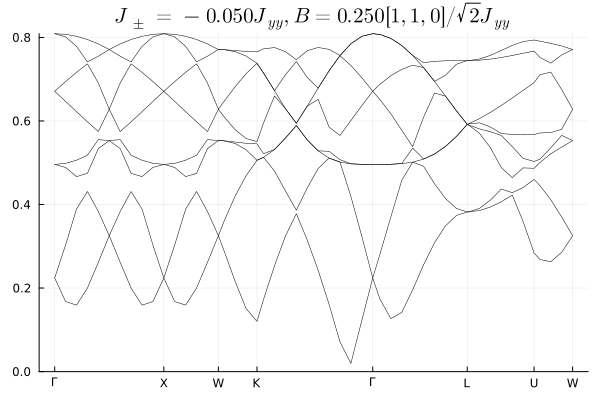

In [33]:
plot_spinons(sim_0_crit_ππ00)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


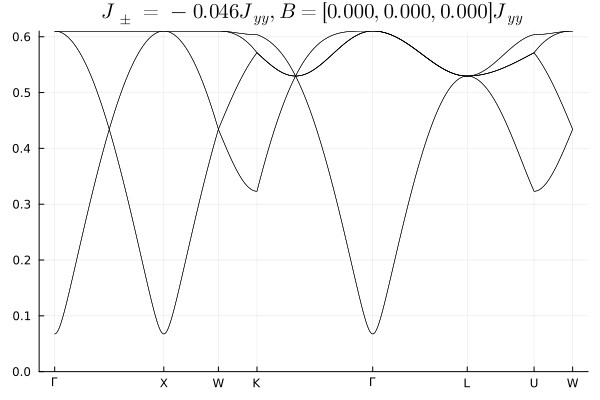

In [160]:
plot_spinons(dict_sim_0[1])
plot!()
# E = reduce(vcat, map(k-> spinon_dispersion(k, sim)[1], path.K )')

# plot(path.t,E)
# xticks!(path.ticks_t, path.ticks_label)
# title!(@sprintf("\$B \\propto [111], J_\\pm=%.3fJ_{yy}, |B|=%.3fJ_{yy}\$",sim.Jpm,norm(sim.B))  )
# savefig(@sprintf("figures/0flux?B111?J_pm=%.3f?B=%.3f.pdf",sim.Jpm,norm(sim.B))  )
# ylims!(0.,maximum(E))

In [12]:
# π-flux + [111] magnetic field
dict_sim_π_111 = map(
    b->SimulationParameters("piflux_111", A=A_dict["πflux"], Jpm=1/3, B=b*ones(3)/√3, nsample=1000, kappa=2.0),
    [0,0.05,0.15,0.2,0.25,0.3]
    );

In [13]:
dict_sim_π_110 = map(
    b->SimulationParameters("piflux_110", A=A_dict["πflux"], Jpm=1/3, B=b*[1,1,0]/√2, nsample=1000, kappa=2.0),
    [0,0.05,0.15,0.2,0.25,0.3]
    );

In [15]:
for sim in dict_sim_π_111
    plot_spinons(sim)
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


In [16]:
for sim in dict_sim_π_110
    plot_spinons(sim)
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


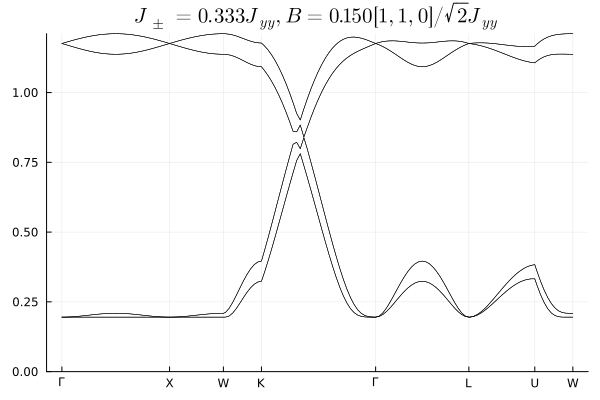

In [106]:
plot_spinons(dict_sim_π_110[3])

In [211]:
Jpm = -0.05

# phase transition 0-> ππ00 is at B = √(9/5 * -Jpm) 
Bmin =sqrt(-9*Jpm/5)
println(Bmin)

dict_sim_ππ00 = [SimulationParameters("pipi00", A=A_dict["ππ00"], Jpm=-0.05, B=B0*[1,1,0]/sqrt(2), nsample=1000, kappa=2.0) for B0 in (Bmin, Bmin+0.1, Bmin+0.2,Bmin+0.3)] 

0.3


4-element Vector{SimulationParameters}:
 SimulationParameters([0.0 0.0 0.0 3.141592653589793; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 3.141592653589793; 0.0 0.0 0.0 0.0], -0.05, [0.21213203435596423, 0.21213203435596423, 0.0], 0.20800254892378145, Main.SpinonStructure.PyrochloreGeometry.PyroFCC(1, SVector{3, Int64}[[0, 0, 0], [0, 4, 4], [4, 0, 4], [4, 4, 0], [2, 2, 2], [2, 6, 6], [6, 2, 6], [6, 6, 2]], SVector{3, Int64}[[0, 0, 0], [0, 4, 4], [4, 0, 4], [4, 4, 0]], SVector{3, Int64}[[1, 1, 1], [1, -1, -1], [-1, 1, -1], [-1, -1, 1], [1, 5, 5], [1, 3, 3], [-1, 5, 3], [-1, 3, 5], [5, 1, 5], [5, -1, 3], [3, 1, 3], [3, -1, 5], [5, 5, 1], [5, 3, -1], [3, 5, -1], [3, 3, 1]]), "pipi00")
 SimulationParameters([0.0 0.0 0.0 3.141592653589793; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 3.141592653589793; 0.0 0.0 0.0 0.0], -0.05, [0.282842712474619, 0.282842712474619, 0.0], 0.24594125648108736, Main.SpinonStructure.PyrochloreGeometry.PyroFCC(1, SVector{3, Int64}[[0, 0, 0], [0, 4, 4], [4, 0, 4], [4, 4, 0], [2, 2, 2], [2, 6, 

In [18]:
for sim in dict_sim_ππ00
    plot_spinons(sim)
end

# Frustrated flux case

The run stored in "FF_Even" has fluxes of $2\pi/3$ on the 0 plaquettes, $-2\pi/9$ on the other three. This is realised when 
$$J_\pm/B^2 = 5\frac{x/9 -1}{6(1-x)}$$

where $x = g_0/g_1 < 0$




In [15]:
"""
Returns the ratio of g0 to g1 in the special case B || [111], given a particular value of Φ0
"""
g0_g123_ratio_from_flux(desired_Φ0) = (1-4*cos(desired_Φ0/3)^2)^-1

"""
FF_111_B(desired_Φ, Jpm)
-> B

x = g0/g1 <0

Returns the (111) field needed to realise the prescribed field
"""
function FF_111_B(desired_Φ0, Jpm)
    # x = Φ0 -> ( 1 - 2*cos((π/2 - Φ0)*2/3) )^-1;
    xp = g0_g123_ratio_from_flux(desired_Φ0)
    
    B = sqrt(Jpm* 6*(1-xp)/ (xp*5/9 - 5) )
    return B
end

FF_111_B

In [16]:
lat = geom.PyroFCC(3)
calc_fluxes(lat, A_dict["FF_even"])/ π

108×4 Matrix{Float64}:
 0.666667  -0.222223  -0.222223  -0.22222
 0.666666  -0.222223  -0.222222  -0.222221
 0.666667  -0.222222  -0.222222  -0.222223
 0.666665  -0.222222  -0.222221  -0.222222
 0.666667  -0.222222  -0.222221  -0.222223
 0.666667  -0.222223  -0.222222  -0.222222
 0.666666  -0.222223  -0.222223  -0.22222
 0.666666  -0.222223  -0.222222  -0.222221
 0.666667  -0.222222  -0.222223  -0.222223
 0.666666  -0.222223  -0.222222  -0.222221
 0.666667  -0.222221  -0.222223  -0.222223
 0.666667  -0.222222  -0.222223  -0.222222
 0.666666  -0.222222  -0.222222  -0.222222
 ⋮                               
 0.666667  -0.222224  -0.222222  -0.222221
 0.666667  -0.222223  -0.222222  -0.222222
 0.666666  -0.222222  -0.222221  -0.222223
 0.666666  -0.222223  -0.222222  -0.222221
 0.666667  -0.222222  -0.222222  -0.222223
 0.666666  -0.222221  -0.222224  -0.222222
 0.666666  -0.222222  -0.222223  -0.222222
 0.666667  -0.222222  -0.222222  -0.222222
 0.666665  -0.222223  -0.222221  -0.222221

In [210]:
Φ0 = 2π/3

dict_sim_FF_Even = map(
    Jpm->SimulationParameters("FF",
        A=A_dict["FF_even"], 
        Jpm=Jpm,
        B=FF_111_B(Φ0, Jpm)* [1.,1.,1.]/sqrt(3),
        nsample=1000,
        kappa=2.0
    ),
    [-0.01, -0.02, -0.05, -0.1]
)


LoadError: UndefVarError: `FF_111_B` not defined

In [18]:
[ sim.Jpm * norm(sim.B)^(-2) for sim in dict_sim_FF_Even ]

4-element Vector{Float64}:
 -0.5177614461033616
 -0.5177614461033616
 -0.5177614461033614
 -0.5177614461033617

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


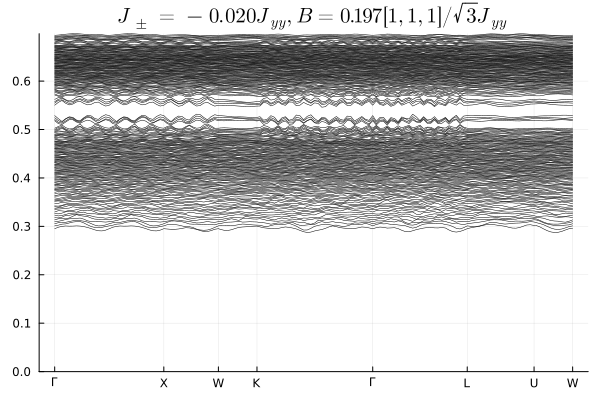

In [45]:
## The FF-flux cases
path = generate_path(high_symmetry_points, split("\\Gamma X W K \\Gamma L U W"), points_per_unit=30, K_units=4π/8)

plot_spinons( dict_sim_FF_Even[2] )


In [205]:

function calc_M(K)
    A = A_dict["FF_even"]
    B = @SVector Float64[0,0,0]
    lat = SpinonStructure.geom.PyroFCC(3)
    return SpinonStructure.calc_xxz_hopping_fast(lat, K, A) + SpinonStructure.calc_nn_hopping(lat, K, A, B)
end

L = 3
k = @SVector [1.,2,3]
swap = zeros(8*L^3,8*L^3)
swap[1:4L^3,4L^3+1:8L^3] = diagm(ones(4 *L^3))
swap += swap'

calc_M(k)-conj(calc_M(-k))



216×216 Matrix{ComplexF64}:
       0.0+0.0im        0.0994051-0.0444336im  …        0.0+0.0im
 0.0994051+0.0444336im        0.0+0.0im                 0.0+0.0im
  0.142526+0.474089im   -0.354096+0.305829im            0.0+0.0im
  0.097348-0.153097im   0.0748034+0.011001im            0.0+0.0im
       0.0+0.0im        0.0400385+0.0345809im           0.0+0.0im
       0.0+0.0im              0.0+0.0im        …        0.0+0.0im
       0.0+0.0im              0.0+0.0im                 0.0+0.0im
       0.0+0.0im        -0.142568-0.474228im            0.0+0.0im
       0.0+0.0im              0.0+0.0im                 0.0+0.0im
  0.332822-0.287456im         0.0+0.0im                 0.0+0.0im
 -0.434285-0.0638681im        0.0+0.0im        …        0.0+0.0im
       0.0+0.0im              0.0+0.0im                 0.0+0.0im
       0.0+0.0im        -0.289769+0.250271im            0.0+0.0im
          ⋮                                    ⋱           ⋮
       0.0+0.0im              0.0+0.0im              

# some quick notes

- FF signature seems to be an opening of a gap in the spectrum (should maifest similar to πflux - 3 peaks of SW, but much broader)
- Still need to check effect of magnetic field on 0 and  π flux (expect quick)
- Note BZ seems too large (L=3) - this is due to imperfect flux configuration, strong competition of energy scales - even 10^-5 flux disorder damages the dispersion (have seen similar behaviour in πflux)
- reduced "magnetic" BZ can stil be seen clearly higher in the spectrum (much less sensitive to disorder)
- Random translation responsible for poor alignment of the oscillations with the "high symmetry" points

In [206]:
# define static convenience types

const Vec3 = geom.Vec3;
const Vec3_F64 = geom.Vec3_F64;
################################################################################
### Calculating the spectral weight
################################################################################

"""
	specweight_at(q, Δ, sim)
	-> E, S

Calculates the contribution of kspace points(q ± Δ) to the Δ integral in 
`spectral_weight`. Let there be N tetrahedra in `sim`, i.e. N bands.
Returns: 
`E`, an (N, N) matrix of e1 + e2 energies corresponding to Dirac delta peaks
`S`, an (N, N) matrix of spectral weights giving the heights of these peaks
"""
function specweight_at(q::Vec3_F64, p::Vec3_F64, sim::SimulationParameters)
    S = 0
    
    E1, U1 = spinon_dispersion( p, sim )
    E2, U2 = spinon_dispersion( q-p, sim )

    W = zeros(ComplexF64,4,4)
    
    for μ=1:4, ν=1:4
        W[μ,ν] = exp(2im*(q/2 - p)'* (geom.pyro[μ]-geom.pyro[ν]))
    end
    

    local f=length(sim.lat.tetra_sites)
    S = zeros(f,f)
    for μ=1:4, ν=1:4
        for (jA, rA) in enumerate(sim.lat.A_sites), (jpA, rpA) in enumerate(sim.lat.A_sites)
            jB = geom.tetra_idx(sim.lat, rA + 2*geom.pyro[μ])
            jpB = geom.tetra_idx(sim.lat, rpA + 2*geom.pyro[ν])

            # the "l" bit
            x1 = U1[jA, :] .* conj(U1[jpA, :]) ./ (2*E1) 
            # the "l'" bit
            x2 = U2[jpB, :] .* conj(U2[jB, :]) ./ (2*E2) # <--- calculation says this one
            # x2 = U2[jB, :] .* conj(U2[jpB, :]) ./ (2*E2) # makes no difference 
            
            
            S += W[μ,ν]*exp(1im*(sim.A[jA,μ]-sim.A[jpA, ν])) * x2*x1'
        end
    end
    E = [e1 + e2 for e2 in E2, e1 in E1]::Matrix{Float64}
    return E, S
end



specweight_at

In [207]:


"""
    spectral_weight(q, Egrid, sim::SimulationParameters, 
						 nsample::Int=1000, grid_density::Int=1000
						 )

Calculates the spectral weight at point `q`.

This performs a Monte Carlo integral over the Brillouin zone.
`grid_density` sets the number of points in one dimension of the Brillouin zone.
`nsample` is the number of these k-points to sample.

"""
function spectral_weight(q::Vec3_F64, Egrid::Vector{Float64}, sim::SimulationParameters, 
						 integral_params::IntegrationParameters
						 )
    # cursed Monte Carlo integration
    grid_density=integral_params.BZ_grid_density

    Sqω = zeros(ComplexF64,size(Egrid))
    # perform an MC integral
    # dE = (Egrid[2]-Egrid[1])*broaden_factor

    bounds = [Inf, -Inf]
    
    for _ = 1:integral_params.n_K_samples
        
        p = (1 .- 2 .*(@SVector rand(3)))*8π/8
        
        Enm, Snm = specweight_at(q, p, sim)
        Sqω += map(
            e-> sum( [S*Lorentzian(e - E, integral_params.broadening_dE) for (E,S) in zip(Enm,Snm)]),
                Egrid)
        bounds[1] = min(bounds[1], reduce(min,  Enm) ) 
        bounds[2] = max(bounds[2], reduce(max,  Enm) )
    end
    return Sqω, bounds
end

spectral_weight

In [20]:
function spectral_density_of_states(q::Vec3_F64, Egrid::Vector{Float64}, sim::SimulationParameters, 
						 integral_params::IntegrationParameters
						 )
    # cursed Monte Carlo integration
    num_flavours = div(length(sim.A),2)
    res = 0

    grid_density=integral_params.BZ_grid_density

    # p_vals = (@SMatrix rand((-grid_density,grid_density),integral_params.n_K_samples,3))*4π/8/grid_density
    p_vals = (1 .- 2 .*(@SMatrix rand(integral_params.n_K_samples,3)))*4π/8
    
    Sqω = zeros(ComplexF64,size(Egrid))
    

    bounds = [Inf, -Inf]
    
    # perform an MC integral
    for p in eachrow(p_vals)
        E1, U1 = spinon_dispersion( q+p, sim)
        E2, U2 = spinon_dispersion( q-p, sim)
        Enm = [e1 + e2 for e2 in E2, e1 in E1]
        Sqω += map( e-> sum([Lorentzian(e - E, integral_params.broadening_dE) for E in Enm]),
                Egrid)
        
        bounds[1] = min(bounds[1], reduce(min,  Enm) ) 
        bounds[2] = max(bounds[2], reduce(max,  Enm) )
    end
    return Sqω, bounds
end

using FastGaussQuadrature

function spectral_density_of_states_GL(q::Vec3_F64, Egrid::Vector{Float64}, sim::SimulationParameters, 
						 integral_params::IntegrationParameters
						 )
    num_flavours = div(length(sim.A),2)
    res = 0

    
    Sqω = zeros(ComplexF64,size(Egrid))

    bounds = [Inf, -Inf]
    ns = integral_params.n_K_samples
    
    ξ, w = gausslegendre( ns )
    
    px = ξ .* (π / 8 / sim.lat.L)
    py = ξ .* (π / 8 / sim.lat.L)
    pz = ξ .* (π / 8 / sim.lat.L)
    
    for ix=1:ns, iy=1:ns, iz=1:ns
        p = @SVector [ px[ix], py[iy], pz[iz] ]
        E1, U1 = spinon_dispersion( q+p, sim)
        E2, U2 = spinon_dispersion( q-p, sim)
        Enm = [e1 + e2 for e2 in E2, e1 in E1]
        Sqω += w[ix]*w[iy]*w[iz]*map( e-> sum([Lorentzian(e - E, integral_params.broadening_dE) for E in Enm]),
                Egrid)
        
        bounds[1] = min(bounds[1], reduce(min,  Enm) ) 
        bounds[2] = max(bounds[2], reduce(max,  Enm) )
    end
    return Sqω* (π / 8 / sim.lat.L)^3/8, bounds
end

spectral_density_of_states_GL (generic function with 1 method)

In [16]:
function integrated_specweight(sim::SimulationParameters, 
						 integral_params::IntegrationParameters,
        Egrid::Vector{Float64}
						 )
    Sω = zeros(ComplexF64,size(Egrid))
    p = Progress(integral_params.n_K_samples)
    @Threads.threads for _ = 1:integral_params.n_K_samples  
        q = (1 .- 2 .*(@SVector rand(3)))*4π/8
        s, _ = spectral_weight(q, Egrid, sim, integral_params)
        Sω += s
        next!(p)
    end
    return Sω
end  

integrated_specweight (generic function with 1 method)

In [163]:
path = generate_path(high_symmetry_points, split("\\Gamma X W K \\Gamma L U W"), points_per_unit=10, K_units=4π/8)

function run_sim(sim::SimulationParameters, ip::IntegrationParameters, Egrid::Vector{Float64})
    
    num_K = length(path.K)
    
    S = zeros(ComplexF64, num_K, length(Egrid))
    bounds = zeros(Float64, num_K, 2)
    

    p = Progress(num_K)

    
    Threads.@threads for I = 1:num_K
        k = path.K[I]*0.5
        q = SVector(k[1], k[2], k[3])
        S[I, :], bounds[I,:] = spectral_weight(q, Egrid, sim, ip)
        # S[I, :], bounds[I,:] = spectral_density_of_states_GL(q, Egrid, sim, ip)
        next!(p)
    end
    
    finish!(p)

    # save the data
    save_SQW(S=S, bounds=bounds, BZ_path=path, Egrid=collect(Egrid), sim=sim, ip=ip)
end

run_sim (generic function with 1 method)

In [18]:
ip_GL = IntegrationParameters(n_K_samples=8,BZ_grid_density=50,broadening_dE=0.2)

ip_very_fast = IntegrationParameters(n_K_samples=10,BZ_grid_density=50,broadening_dE=0.02)
ip_fast = IntegrationParameters(n_K_samples=100,BZ_grid_density=50,broadening_dE=0.02)
ip_slow = IntegrationParameters(n_K_samples=1000,BZ_grid_density=500,broadening_dE=0.02)
ip_very_slow = IntegrationParameters(n_K_samples=10000,BZ_grid_density=500,broadening_dE=0.02)


IntegrationParameters(10000, 500, 0.02)

In [232]:
function plot_spin_corr(data)
    d = data["intensity"]
    p = heatmap(d["tau"],d["W"],real.(d["S"])')
    plot!(d["tau"], d["bounds"], linecolor=:white)
    xticks!(d["ticks_tau"],d["ticks_label"])
    plot!(legend=nothing)

    sim =data["physical_parameters"]

    B = sim["B"]
    vline!(d["ticks_tau"], linecolor=:white, linestyle=:dash)
    
    bstr = @sprintf("[%.3f,%.3f,%.3f]",B[1],B[2],B[3])  
    if norm( abs.(B/norm(B))- [1,1,1]/√3) < 1e-8
        bstr = @sprintf("%.3f [1,1,1]/\\sqrt{3}", norm(B) )
    elseif norm( abs.(B/norm(B))- [1,1,0]/√2) < 1e-8
        bstr = @sprintf("%.3f [1,1,0]/\\sqrt{2}", norm(B))
    end
    title!(@sprintf("\$J_\\pm=%.3fJ_{yy}, B=%s J_{yy}\$",sim["Jpm"],bstr))
    savefig(@sprintf("figures/specweight_%s?J_pm=%.3f?B=[%.3f,%.3f,%.3f].pdf",sim["name"],sim["Jpm"],B[1],B[2],B[3])  )
    return p
end

plot_spin_corr (generic function with 1 method)

In [212]:
Egrid = collect(range(0,1.3,1000));
for sim in dict_sim_0
    run_sim(sim, ip_very_slow, Egrid)
end

Progress: 100%|█████████████████████████████████████████| Time: 0:08:04
Progress: 100%|█████████████████████████████████████████| Time: 0:08:48
Progress: 100%|█████████████████████████████████████████| Time: 0:08:52
Progress: 100%|█████████████████████████████████████████| Time: 0:08:57
Progress: 100%|█████████████████████████████████████████| Time: 0:08:58
Progress: 100%|█████████████████████████████████████████| Time: 0:08:47


In [209]:
Egrid = collect(range(0,3,1000));
for sim in dict_sim_π_110
    run_sim(sim, ip_very_slow, Egrid)
end
for sim in dict_sim_π_111
    run_sim(sim, ip_very_slow, Egrid)
end

Progress: 100%|█████████████████████████████████████████| Time: 0:08:04
Progress: 100%|█████████████████████████████████████████| Time: 0:09:00
Progress: 100%|█████████████████████████████████████████| Time: 0:08:54
Progress: 100%|█████████████████████████████████████████| Time: 0:08:53
Progress: 100%|█████████████████████████████████████████| Time: 0:08:44
Progress: 100%|█████████████████████████████████████████| Time: 0:08:58
Progress: 100%|█████████████████████████████████████████| Time: 0:08:27
Progress: 100%|█████████████████████████████████████████| Time: 0:09:05
Progress: 100%|█████████████████████████████████████████| Time: 0:09:02
Progress: 100%|█████████████████████████████████████████| Time: 0:09:03
Progress: 100%|█████████████████████████████████████████| Time: 0:08:59
Progress: 100%|█████████████████████████████████████████| Time: 0:08:54


In [233]:
# plot everything
for sim in dict_sim_π_110
    plot_spin_corr(load(simname(sim)))
end
for sim in dict_sim_π_111
    plot_spin_corr(load(simname(sim)))
end

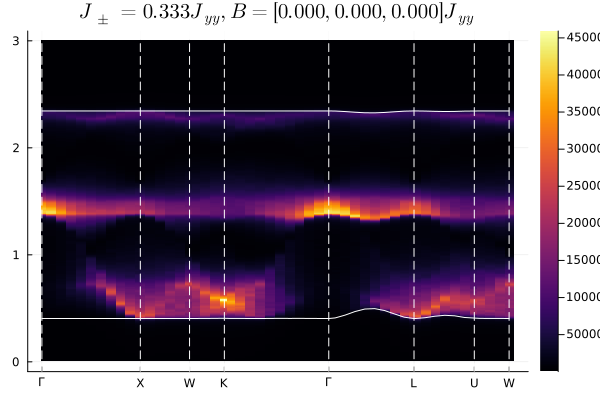

In [222]:
# plot_spin_corr(load(simname(dict_sim_0[1])))
plot_spin_corr(load(simname(dict_sim_π_110[1])))
# plot_spin_corr(load(simname(dict_sim_π_111[1])))

In [239]:
total_spec_π_111 = []

for sim in dict_sim_π_111
    push!(total_spec_π_111, integrated_specweight(sim,ip_slow, Egrid))
end

Progress: 100%|█████████████████████████████████████████| Time: 0:15:04
Progress: 100%|█████████████████████████████████████████| Time: 0:16:40
Progress: 100%|█████████████████████████████████████████| Time: 0:16:56
Progress: 100%|█████████████████████████████████████████| Time: 0:17:11
Progress: 100%|█████████████████████████████████████████| Time: 0:18:08
Progress: 100%|█████████████████████████████████████████| Time: 0:17:22


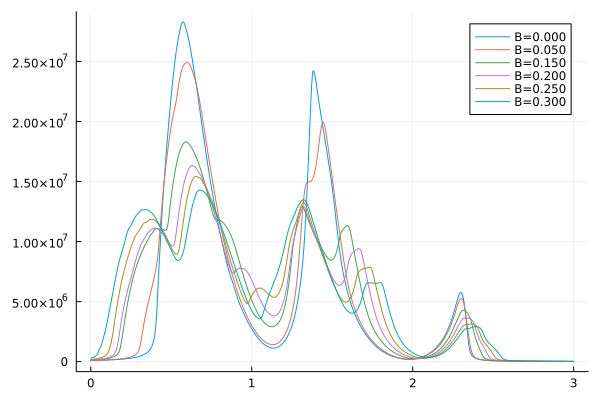

In [240]:
plot()
for (sim, is) in zip(dict_sim_π_111, total_spec_π_111)
    plot!(Egrid, real.(is), label=@sprintf("B=%.3f",norm(sim.B)))
end
plot!()

In [213]:
Egrid = collect(range(0,3,1000));
for sim in dict_sim_FF_Even
    run_sim(sim, ip_fast, Egrid)
end

LoadError: UndefVarError: `dict_sim_FF_Even` not defined

In [ ]:
plot_spin_corr( load(simname(dict_sim_0[1]) ) )

In [27]:
total_S = integrated_specweight(dict_sim_FF_Even[2], ip_very_fast, Egrid)

LoadError: UndefVarError: `dict_sim_FF_Even` not defined

In [153]:
using BlockArrays
# k = @SVector Float64[2π/8,0.5,0.1]

e, u = spinon_dispersion(k, dict_sim_0[1])
perm = [2,4,6,8,1,3,5,7]

# u2 = u[:,perm]
# e2 = e[perm]

# v = [ 1 0 0 1;
#       0 1 1 0;
#       0 1 -1 0;
#       -1 0 0 1 ]

# v = v/det(v)

# # u3 = u2*Matrix(
# V = zeros(ComplexF64,8,8)
# V[1:4, 1:4] = v
# V[5:8, 5:8] = v
# W = zeros(ComplexF64,8,8)
# W[1:2,1:2] = [ -1 1; -1 -1]
# W[3:4,3:4] = [ 1 1; 1 -1]
# W[5:6,5:6] = [ -1 1; -1 -1]
# W[7:8,7:8] = [ 1 1; 1 -1]
ϕ, v = eigen(u)

    
# u3 = u2*V

# h = SpinonStructure.calc_xxz_hopping_fast(dict_sim_0[1].lat, k,  dict_sim_0[1].A)

# heatmap(real.(adjoint(u2)*h*u2))
# heatmap(real.(u2))

Eigen{ComplexF64, ComplexF64, Matrix{ComplexF64}, Vector{ComplexF64}}
values:
8-element Vector{ComplexF64}:
                 -1.0 + 0.0im
   -0.999999999999999 - 3.881750082051638e-16im
 -0.49999999999999967 - 0.8660254037844385im
 -0.49999999999999956 + 0.8660254037844389im
  0.49999999999999983 - 0.8660254037844385im
                  0.5 + 0.8660254037844394im
                  1.0 + 0.0im
   1.0000000000000002 + 0.0im
vectors:
8×8 Matrix{ComplexF64}:
    0.0453885+0.0167598im    …  8.65961e-17+1.96086e-32im
     0.520865+0.0im                0.577048+0.0im
  6.40578e-17-1.26115e-17im       -0.304703-6.68952e-32im
    -0.475476+0.0167598im         -0.272345-3.39823e-33im
     0.475476-0.0167598im         -0.272345+8.35254e-33im
    0.0453885+0.0167598im    …  3.91517e-16+1.51371e-32im
     0.520865+1.73472e-18im       -0.577048-1.92985e-33im
 -7.11101e-18+3.41574e-18im       -0.304703+6.5281e-32im

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


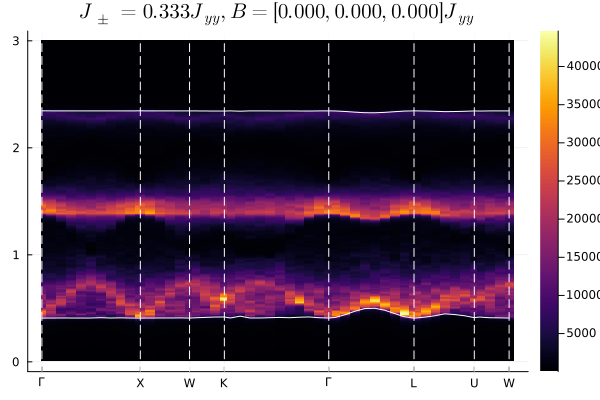

In [155]:
Egrid = collect(range(0,3,1000));

sim = dict_sim_π_111[1]
run_sim(sim, ip_slow, Egrid)
plot_dispersion( load(simname(sim) ) )

In [234]:
? load

search: load load_A LoadError loadparams! LOAD_PATH @load download unsafe_load



  * `load(filename)` loads the contents of a formatted file, trying to infer the format from `filename` and/or magic bytes in the file (see [`query`](@ref)).
  * `load(strm)` loads from an `IOStream` or similar object. In this case, there is no filename extension, so we rely on the magic bytes for format identification.
  * `load(File{format"PNG"}(filename))` specifies the format directly, and bypasses the format [`query`](@ref).
  * `load(Stream{format"PNG"}(io))` specifies the format directly, and bypasses the format [`query`](@ref).
  * `load(f; options...)` passes keyword arguments on to the loader.


In [18]:
Egrid = collect(range(0,2,100));
res_ππ00 = run_sim(sim_ππ00, ip_slow, Egrid)

Progress: 100%|█████████████████████████████████████████| Time: 0:03:05


185.495425 seconds (1.93 G allocations: 110.286 GiB, 14.24% gc time, 585.00% compilation time)


"output/SQW?name=ππ00?Jpm=-0.05?B=[0.0, 0.21213203435596423, 0.21213203435596423].jld"

In [ ]:
Egrid = collect(range(0,2,100));
res_FF_Even = run_sim(sim_FF_Even, ip_fast, Egrid)

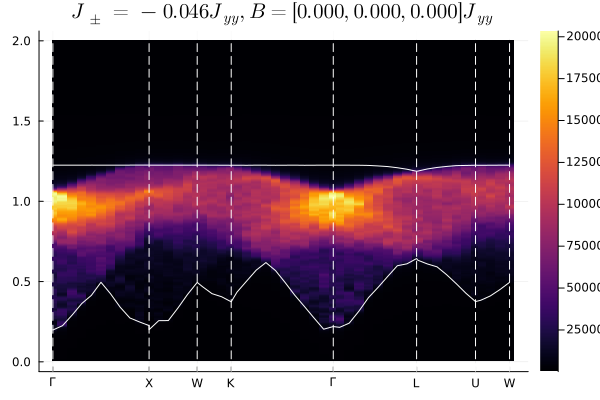

In [102]:
plot_dispersion( load(simname(dict_sim_0[1]) ) )

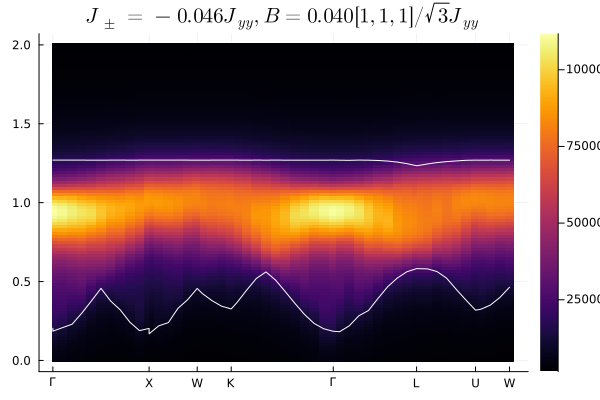

In [182]:
plot_dispersion( load(simname(dict_sim_0[5]) ) )

In [ ]:
plot_dispersion( load(simname(dict_sim_π_111[1]) ) )


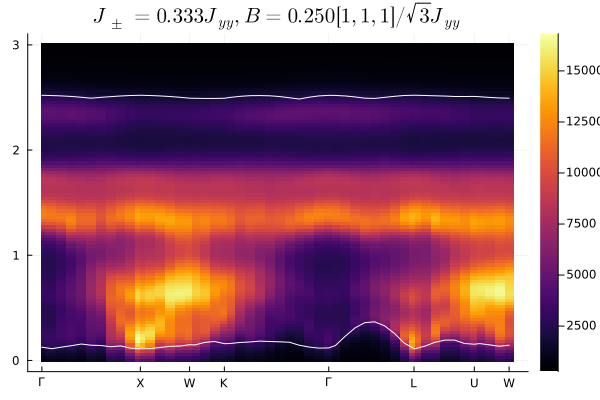

In [185]:
plot_dispersion( load(simname(dict_sim_π_111[5]) ) )

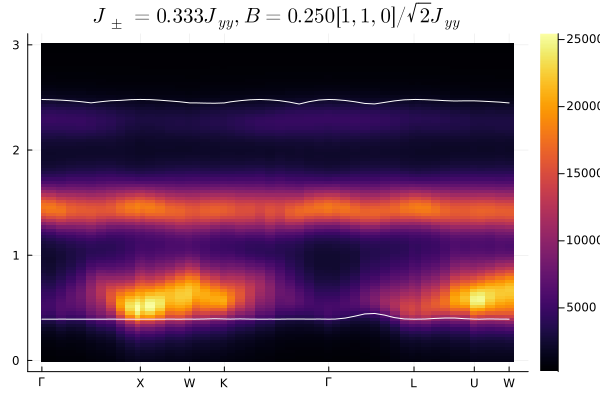

In [186]:
plot_dispersion( load(simname(dict_sim_π_110[5]) ) )

In [ ]:
# res_FF_Even = 
for sim in dict_sim_FF_Even
    run_sim(sim, ip_fast, Egrid)
end

In [ ]:
plot_dispersion( load(simname(dict_sim_FF_Even[1]) ) )

In [ ]:
plot_dispersion( load(simname(dict_sim_FF_Even[2]) ) )

In [ ]:
plot_dispersion( load(simname(dict_sim_FF_Even[3]) ) )

In [ ]:
plot_dispersion( load(simname(dict_sim_FF_Even[4]) ) )

In [ ]:
using LaTeXStrings
plot_font = "Computer Modern"
default(
    fontfamily=plot_font,
    linewidth=2, 
    framestyle=:box, 
    label=nothing, 
    grid=false
)

function get_FCC_WS_edges()

    squareX = [
        [1.,  0.5,    0],
        [1.,  0.,  -0.5],
        [1., -0.5,    0],
        [1.,  0.,   0.5],
        [1.,  0.5,    0]
    ]
    neg_squareX= map(x->x.*[-1,1,1], squareX)

    hexa_111 = [
        [1. , 0.5, 0.],
        [0.5, 1. , 0.],
        [0. , 1., 0.5],
        [0., 0.5 , 1.],
        [0.5, 0. , 1.],
        [1., 0., 0.5]
    ]

    square_faces = [
        squareX,
        neg_squareX,
        circshift.(squareX,1),
        circshift.(neg_squareX,1),
        circshift.(squareX,2),
        circshift.(neg_squareX,2)
    ]

    # unused right now, but might come in handy some day
    # hexagons = [
    #     hexa_111,
    #     map(x->x.*[-1,-1,1], hexa_111),
    #     map(x->x.*[-1,1,-1], hexa_111),
    #     map(x->x.*[1,-1,-1], hexa_111),
    #     map(x->x.*[-1,1,1], hexa_111),
    #     map(x->x.*[1,-1,1], hexa_111),
    #     map(x->x.*[1,1,-1], hexa_111),
    #     map(x->x.*[-1,-1,-1], hexa_111)
    # ]

    e0 = [
        [ [ 1.,  0.5, 0.], [ 0.5,  1., 0.] ],
        [ [ 1., -0.5, 0.], [ 0.5, -1., 0.] ],
        [ [-1., -0.5, 0.], [-0.5, -1., 0.] ],
        [ [-1.,  0.5, 0.], [-0.5,  1., 0.] ],
    ]
    edges = copy(e0)
    append!(edges, map( l -> circshift.(l,1), e0))
    append!(edges, map( l -> circshift.(l,2), e0))

    return vcat(square_faces, edges)
end
    
p = plot(camera=(80,15))

for f in get_FCC_WS_edges()
    ff = reduce(hcat, f)
    plot!( ff[1,:],ff[2,:],ff[3,:], linecolor="black", linewidth=.5 )
end

X = []
for (label, x) in high_symmetry_points
    push!(labels, label)
    push!(X, x)
    annotate!(x[1],x[2],x[3],text("\$$(label)\$",:left,:bottom))
end
X= reduce(hcat, X)
plot!(X[1,:],X[2,:],X[3,:], seriestype=:scatter)

kk = reduce(hcat, path.K)'*8/2/π
plot!(kk[:,1],kk[:,2],kk[:,3],linecolor=:red)
display(p)